# Your Title Here

**Name(s)**: Ethan Cao

**Website Link**: (your website link)

## Code

In [115]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
pd.options.plotting.backend = 'plotly'
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

### Framing the Problem

In [116]:
def combine_times(date_col_name, time_col_name, new_col_name, df):
    df = df.copy()
    df[new_col_name] = df[date_col_name] + pd.to_timedelta(df[time_col_name].astype(str))
    return df

data = pd.read_excel("outage.xlsx", skiprows=[0,1,2,3,4,6], index_col=1).iloc[:,1:]
data = combine_times("OUTAGE.START.DATE", 'OUTAGE.START.TIME', 'OUTAGE.START.DATETIME', data)
data = combine_times("OUTAGE.RESTORATION.DATE", "OUTAGE.RESTORATION.TIME", "OUTAGE.RESTORATION.DATETIME", data)

In [117]:
data['CAUSE.CATEGORY'].unique()

array(['severe weather', 'intentional attack',
       'system operability disruption', 'equipment failure',
       'public appeal', 'fuel supply emergency', 'islanding'],
      dtype=object)

In [118]:
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START.DATETIME,OUTAGE.RESTORATION.DATETIME
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,...,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,2011-12-06 08:00:00,2011-12-06 20:00:00
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaT,NaN,...,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaT,NaT
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29,22:54:00,...,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256,2009-08-29 22:54:00,2009-08-29 23:53:00


In [119]:
data['IS.HURRICANE'] = data['HURRICANE.NAMES'].isna() == False

In [120]:
data['MONTH.START'] = data['OUTAGE.START.DATETIME'].apply(lambda x : x.month)

In [193]:
data.columns

Index(['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION',
       'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
       'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
       'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT

In [122]:
data['IS.HURRICANE'].sum()

72

In [86]:
data['CAUSE.CATEGORY'].value_counts()

CAUSE.CATEGORY
severe weather                   763
intentional attack               418
system operability disruption    127
public appeal                     69
equipment failure                 60
fuel supply emergency             51
islanding                         46
Name: count, dtype: int64

In [87]:
793/1534

0.5169491525423728

In [195]:
features = ['POSTAL.CODE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'MONTH', 'CAUSE.CATEGORY']

In [196]:
data['ANOMALY.LEVEL'] = data['ANOMALY.LEVEL'].fillna(0)

In [217]:
px.bar(data,x='CAUSE.CATEGORY',y='CUSTOMERS.AFFECTED')

### Baseline Model

In [255]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.compose import ColumnTransformer



data_class = data[features].dropna()

X = data_class[['POSTAL.CODE', 'ANOMALY.LEVEL', 'MONTH']]
y = data_class['CAUSE.CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
col_trans = ColumnTransformer([
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['POSTAL.CODE'])],
    remainder = 'passthrough')
pl = Pipeline([
    ('col_trans', col_trans),
    ('forest', RandomForestClassifier())
])

pl.fit(X_train, y_train)
prediction = pl.predict(X_test)


In [139]:
accuracy_score(y_test, prediction)

0.8443396226415094

In [257]:
import pprint as pp

### Final Model

In [146]:
features = ['POSTAL.CODE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'MONTH','CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY']
data_class = data[features].dropna()

X = data_class[['POSTAL.CODE', 'ANOMALY.LEVEL', 'MONTH','OUTAGE.DURATION','CUSTOMERS.AFFECTED']]
y = data_class['CAUSE.CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
col_trans = ColumnTransformer([
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['POSTAL.CODE'])],
    remainder = 'passthrough')
pl = Pipeline([
    ('col_trans', col_trans),
    ('forest', RandomForestClassifier())
])

pl.fit(X_train, y_train)
prediction = pl.predict(X_test)


In [96]:
param_grid = {"forest__max_depth": np.append(np.arange(5,30),None)}
search = GridSearchCV(pl, param_grid,cv=5)
search.fit(X_train,y_train)

/Users/billwang/anaconda3/envs/DSC80/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one-hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['POSTAL.CODE'])])),
                                       ('forest', RandomForestClassifier())]),
             param_grid={'forest__max_depth': array([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, None], dtype=object)})

In [97]:
search.best_params_

{'forest__max_depth': 24}

In [98]:
search.cv_results_['mean_test_score']

array([0.81161595, 0.82345731, 0.83057199, 0.84596365, 0.85426176,
       0.85902367, 0.85783319, 0.86258101, 0.86613835, 0.86376444,
       0.86730769, 0.8602071 , 0.86612426, 0.86612426, 0.86494787,
       0.86850521, 0.86968864, 0.86731474, 0.86730769, 0.87323894,
       0.86256692, 0.86613835, 0.86493378, 0.86494083, 0.86730065,
       0.86494787])

In [147]:
accuracy_score(y_test, prediction)

0.9009433962264151

### Fairness Analysis

In [148]:
check_diff_class = X_test.assign(prediction = prediction).assign(actual = y_test)
check_diff_class['Predict_right'] = check_diff_class['prediction'] == check_diff_class['actual']
check_diff_class

,POSTAL.CODE,ANOMALY.LEVEL,MONTH,OUTAGE.DURATION,CUSTOMERS.AFFECTED,prediction,actual,Predict_right
OBS,,,,,,,,
1442,MA,0.3,10.0,1656.0,50000.0,severe weather,severe weather,True
986,NY,-0.9,10.0,7962.0,161151.0,severe weather,severe weather,True
617,PA,-0.5,2.0,2668.0,62159.0,severe weather,severe weather,True
850,DC,-1.2,8.0,855.0,101003.0,severe weather,severe weather,True
480,WA,0.9,11.0,5855.0,50000.0,severe weather,severe weather,True
...,...,...,...,...,...,...,...,...
360,IL,-0.3,6.0,1110.0,121000.0,severe weather,severe weather,True
1197,CA,0.4,6.0,400.0,70.0,islanding,islanding,True
1062,FL,-0.3,8.0,90.0,104498.0,severe weather,system operability disruption,False


In [157]:
check_diff_class[['prediction', 'actual', 'Predict_right']].groupby('actual')['Predict_right'].count()

actual
equipment failure                  5
intentional attack                42
islanding                          8
public appeal                      3
severe weather                   136
system operability disruption     18
Name: Predict_right, dtype: int64

In [165]:
check_diff_class['actual'].unique()

array(['severe weather', 'equipment failure', 'islanding',
       'system operability disruption', 'intentional attack',
       'public appeal'], dtype=object)

In [150]:
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START.DATETIME,OUTAGE.RESTORATION.DATETIME,IS.HURRICANE,MONTH.START
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00,False,7.0
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00,False,5.0
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00,False,10.0
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00,False,6.0
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00,False,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,...,3.9,0.27,0.10,97.599649,2.401765,2.401765,2011-12-06 08:00:00,2011-12-06 20:00:00,False,12.0
1531,2006,NaN,North Dakota,ND,MRO,West North Central,0.0,NaN,NaT,NaN,...,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaT,NaT,False,NaN
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29,22:54:00,...,4.7,0.30,0.15,98.307744,1.692256,1.692256,2009-08-29 22:54:00,2009-08-29 23:53:00,False,8.0


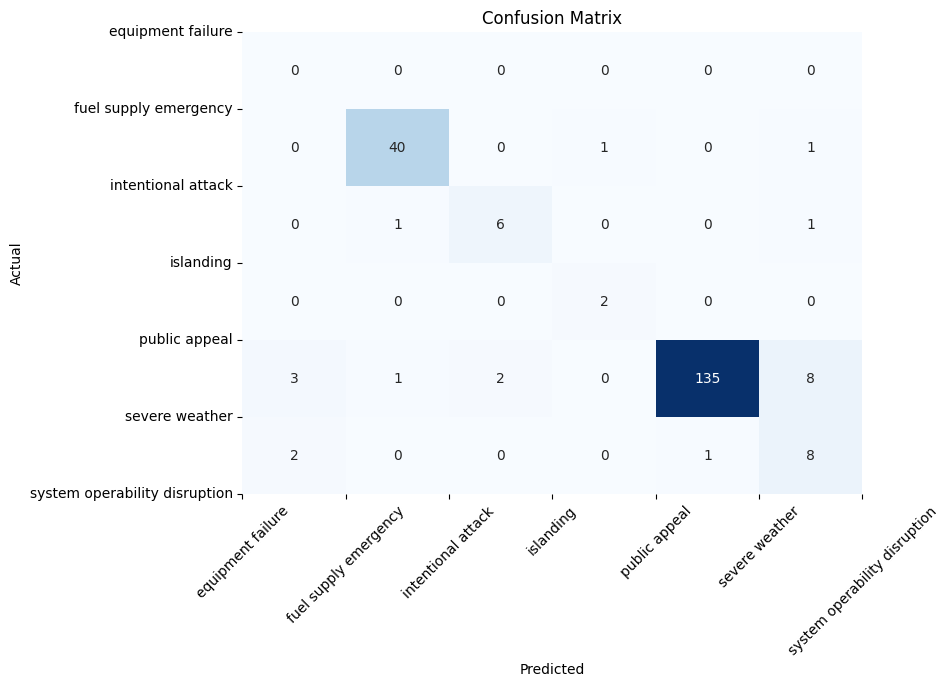

In [152]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
category_labels = [
    'equipment failure',
    'intentional attack',
    'islanding',
    'public appeal',
    'severe weather',
    'system operability disruption'
]

# Assuming 'y_test' contains the true labels and 'prediction' contains predicted labels
cm = confusion_matrix(check_diff_class['prediction'], check_diff_class['actual'])
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(category_labels)), labels=category_labels, rotation=45)
plt.yticks(ticks=range(len(category_labels)), labels=category_labels, rotation=0)
plt.show()



In [163]:
cm

array([[  0,   0,   0,   0,   0,   0],
       [  0,  40,   0,   1,   0,   1],
       [  0,   1,   6,   0,   0,   1],
       [  0,   0,   0,   2,   0,   0],
       [  3,   1,   2,   0, 135,   8],
       [  2,   0,   0,   0,   1,   8]])

In [153]:
# 0 equipment failure                0.000000
# 1 fuel supply emergency            0.000000
# 2 intentional attack               1.000000
# 3 islanding                        0.600000
# 4 public appeal                    0.571429
# 5 severe weather                   0.970803
# 6 system operability disruption    0.217391


In [171]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Replace 'y_test' and 'prediction' with your actual test labels and predictions
# Example data (replace this with your actual data)


# Replace these labels with your specific category names
category_labels = [
    'equipment failure',
    'intentional attack',
    'islanding',
    'public appeal',
    'severe weather',
    'system operability disruption'
]


# Calculate the confusion matrix
cm = confusion_matrix(check_diff_class['prediction'], check_diff_class['actual'])

# Create a Plotly heatmap for the confusion matrix
fig = ff.create_annotated_heatmap(z=cm, x=category_labels, y=category_labels, colorscale='Blues')

# Update the layout
fig.update_layout(title='Confusion Matrix',
                  xaxis=dict(title='Predicted Label'),
                  yaxis=dict(title='True Label'))

# Display the confusion matrix
fig.show()
fig.write_html('confusion_matrix.html', include_plotlyjs='cdn')


In [168]:
from sklearn.metrics import precision_score, recall_score

# Assuming 'y_test' contains the true labels and 'prediction' contains predicted labels
precision = precision_score(y_test, prediction, average='weighted')
recall = recall_score(y_test, prediction, average='weighted')

/Users/billwang/anaconda3/envs/DSC80/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [169]:
precision

0.8741150264196992

In [170]:
recall

0.9009433962264151